In [205]:
import os
import os.path as osp
import json
import pickle
import collections as C
import itertools as I
import random
import regex as re
from typing import List, Optional, Dict, Tuple
import time

import msgspec
from tqdm import tqdm
from loguru import logger
from dacite import from_dict
import dacite

from common.constants import SYSTEM_PROMPT_FPG, CORE_OPTIONS, BANNED_TOKENS
from common.utils import remove_comments, replace_sorry, replace_calc, remove_multiline_comments, remove_singleline_comments, parse_idents, normalize_spaces
from common.pantograph.dataclasses import ProblemGenerationProcess, ProblemGenerationStep, Variable, normalize_draft, replace_span, Goal, GoalState, ProblemGenerationStep, ProblemGenerationProcess, TacticDraft
from common.pantograph.server import PersistentServer, TacticFailure, ServerError
from agent.problem_generation import AutoregressiveProblemGenerationAgent

In [206]:
data_30828_root = '/home/ma-user/workspace/formal_problem_generation/data/FineLeanCorpus/dones'
data_32762_root = '/home/ma-user/workspace/formal_problem_generation/data/FineLeanCorpus/results_32672/raw'
n_chunks = 498

In [ ]:
data_main = []
data_extra = []

for i in range(n_chunks):
    with open(osp.join(data_30828_root, f'done_chunk_{1024 * i}.pkl'), 'rb') as f:
        chunk_30828 = pickle.load(f)
    with open(osp.join(data_32762_root, f'done_chunk_{1024 * i}.pkl'), 'rb') as f:
        chunk_32762 =pickle.load(f)
    
    assert all(d1.informal_problem == d2.informal_problem for (d1, d2) in zip(chunk_30828, chunk_32762))
    if all

In [4]:
data_32762 = []

for i in range(n_chunks):
    with open(osp.join(data_32762_root, f'done_chunk_{1024 * i}.pkl'), 'rb') as f:
        data_32762.extend(pickle.load(f))

In [5]:
print(len(data_30828), len(data_32762))

509358 509358


In [6]:
data_falsified = []
data_reassembled = []
data_decomposed = []
data_proven = []
data_failed = []

In [7]:
for d1, d2 in zip(data_30828, data_32762):
    # if d1 is None:
    #     data_reassembled.append(d2)
    # elif d2 is None:
    #     data_reassembled.append(d1)
    # else:
    assert d1.informal_problem == d2.informal_problem
    meta1 = json.loads(d1.metainfo)
    meta2 = json.loads(d2.metainfo)
    assert meta1['id'] == meta2['id']
    
    # Whether falsified
    if 'falsified_model' in meta1.keys():
        data_falsified.append(d1)
    elif 'falsified_model' in meta2.keys():
        data_falsified.append(d2)
    else:
        # Whether reassembled
        if 'original_trajectory' in meta1.keys():
            data_reassembled.append(d1)
        elif 'original_trajectory' in meta2.keys():
            data_reassembled.append(d2)
        else:
            # Whether decomposed
            if len(d1.trajectory) > 0:
                data_decomposed.append(d1)
            elif len(d2.trajectory) > 0:
                data_decomposed.append(d2)
            else:
                if 'proven_model' in meta1.keys():
                    data_proven.append(d1)
                elif 'proven_model' in meta2.keys():
                    data_proven.append(d2)
                else:
                    data_failed.append(d1)

In [8]:
len(data_falsified), len(data_reassembled), len(data_decomposed), len(data_proven), len(data_failed), 

(2614, 82188, 599, 11375, 412582)

In [9]:
C.Counter(len(d.trajectory) for d in data_reassembled)

Counter({2: 17569,
         4: 12949,
         3: 8625,
         6: 8120,
         8: 6472,
         5: 5328,
         10: 4190,
         7: 3601,
         9: 3224,
         12: 2824,
         11: 2758,
         13: 1643,
         14: 1393,
         15: 1082,
         16: 725,
         17: 449,
         18: 332,
         19: 285,
         20: 164,
         21: 116,
         22: 108,
         23: 52,
         24: 40,
         26: 31,
         27: 23,
         28: 13,
         25: 13,
         31: 12,
         30: 9,
         29: 8,
         33: 6,
         32: 4,
         38: 3,
         35: 2,
         54: 2,
         42: 2,
         36: 2,
         57: 2,
         45: 1,
         55: 1,
         62: 1,
         105: 1,
         39: 1,
         110: 1,
         34: 1})

In [32]:
C.Counter(
    ([t[1] for t in d.trajectory] == list(range(len(d.steps)))) for d in data_reassembled
)

Counter({True: 69888, False: 12300})

In [160]:
for d in data_reassembled:
    if len(d.trajectory) == 62:
        raise

RuntimeError: No active exception to reraise

In [161]:
print(d.formal_solution_draft)

rcases h₂ with ⟨d, hd⟩

have ha1 : a 1 = a 0 + d := by
  specialize hd 0
  norm_num at hd ⊢
  linarith

have ha2 : a 2 = a 1 + d := by
  specialize hd 1
  norm_num at hd ⊢
  linarith

have ha3 : a 3 = a 2 + d := by
  specialize hd 2
  norm_num at hd ⊢
  linarith

have ha4 : a 4 = a 3 + d := by
  specialize hd 3
  norm_num at hd ⊢
  linarith

have ha5 : a 5 = a 4 + d := by
  specialize hd 4
  norm_num at hd ⊢
  linarith

have ha50 : a 50 = a 49 + d := by
  specialize hd 49
  norm_num at hd ⊢
  linarith

have ha49 : a 49 = a 48 + d := by
  specialize hd 48
  norm_num at hd ⊢
  linarith

have ha48 : a 48 = a 47 + d := by
  specialize hd 47
  norm_num at hd ⊢
  linarith

have ha47 : a 47 = a 46 + d := by
  specialize hd 46
  norm_num at hd ⊢
  linarith

have ha46 : a 46 = a 45 + d := by
  specialize hd 45
  norm_num at hd ⊢
  linarith

have ha45 : a 45 = a 44 + d := by
  specialize hd 44
  norm_num at hd ⊢
  linarith

have ha44 : a 44 = a 43 + d := by
  specialize hd 43
  norm_num at hd ⊢


In [163]:
print(d.formal_statement)

example (a : ℕ → ℝ) (h₀ : a 1 = 1 / 3) (h₁ : a 2 + a 5 = 4)
    (h₂ : ∃ d, ∀ n, a (n + 1) = a n + d) :
    a 50 = 33 := sorry


In [164]:
len(d.steps)

62

/tmp/ipykernel_1841300/1048102395.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


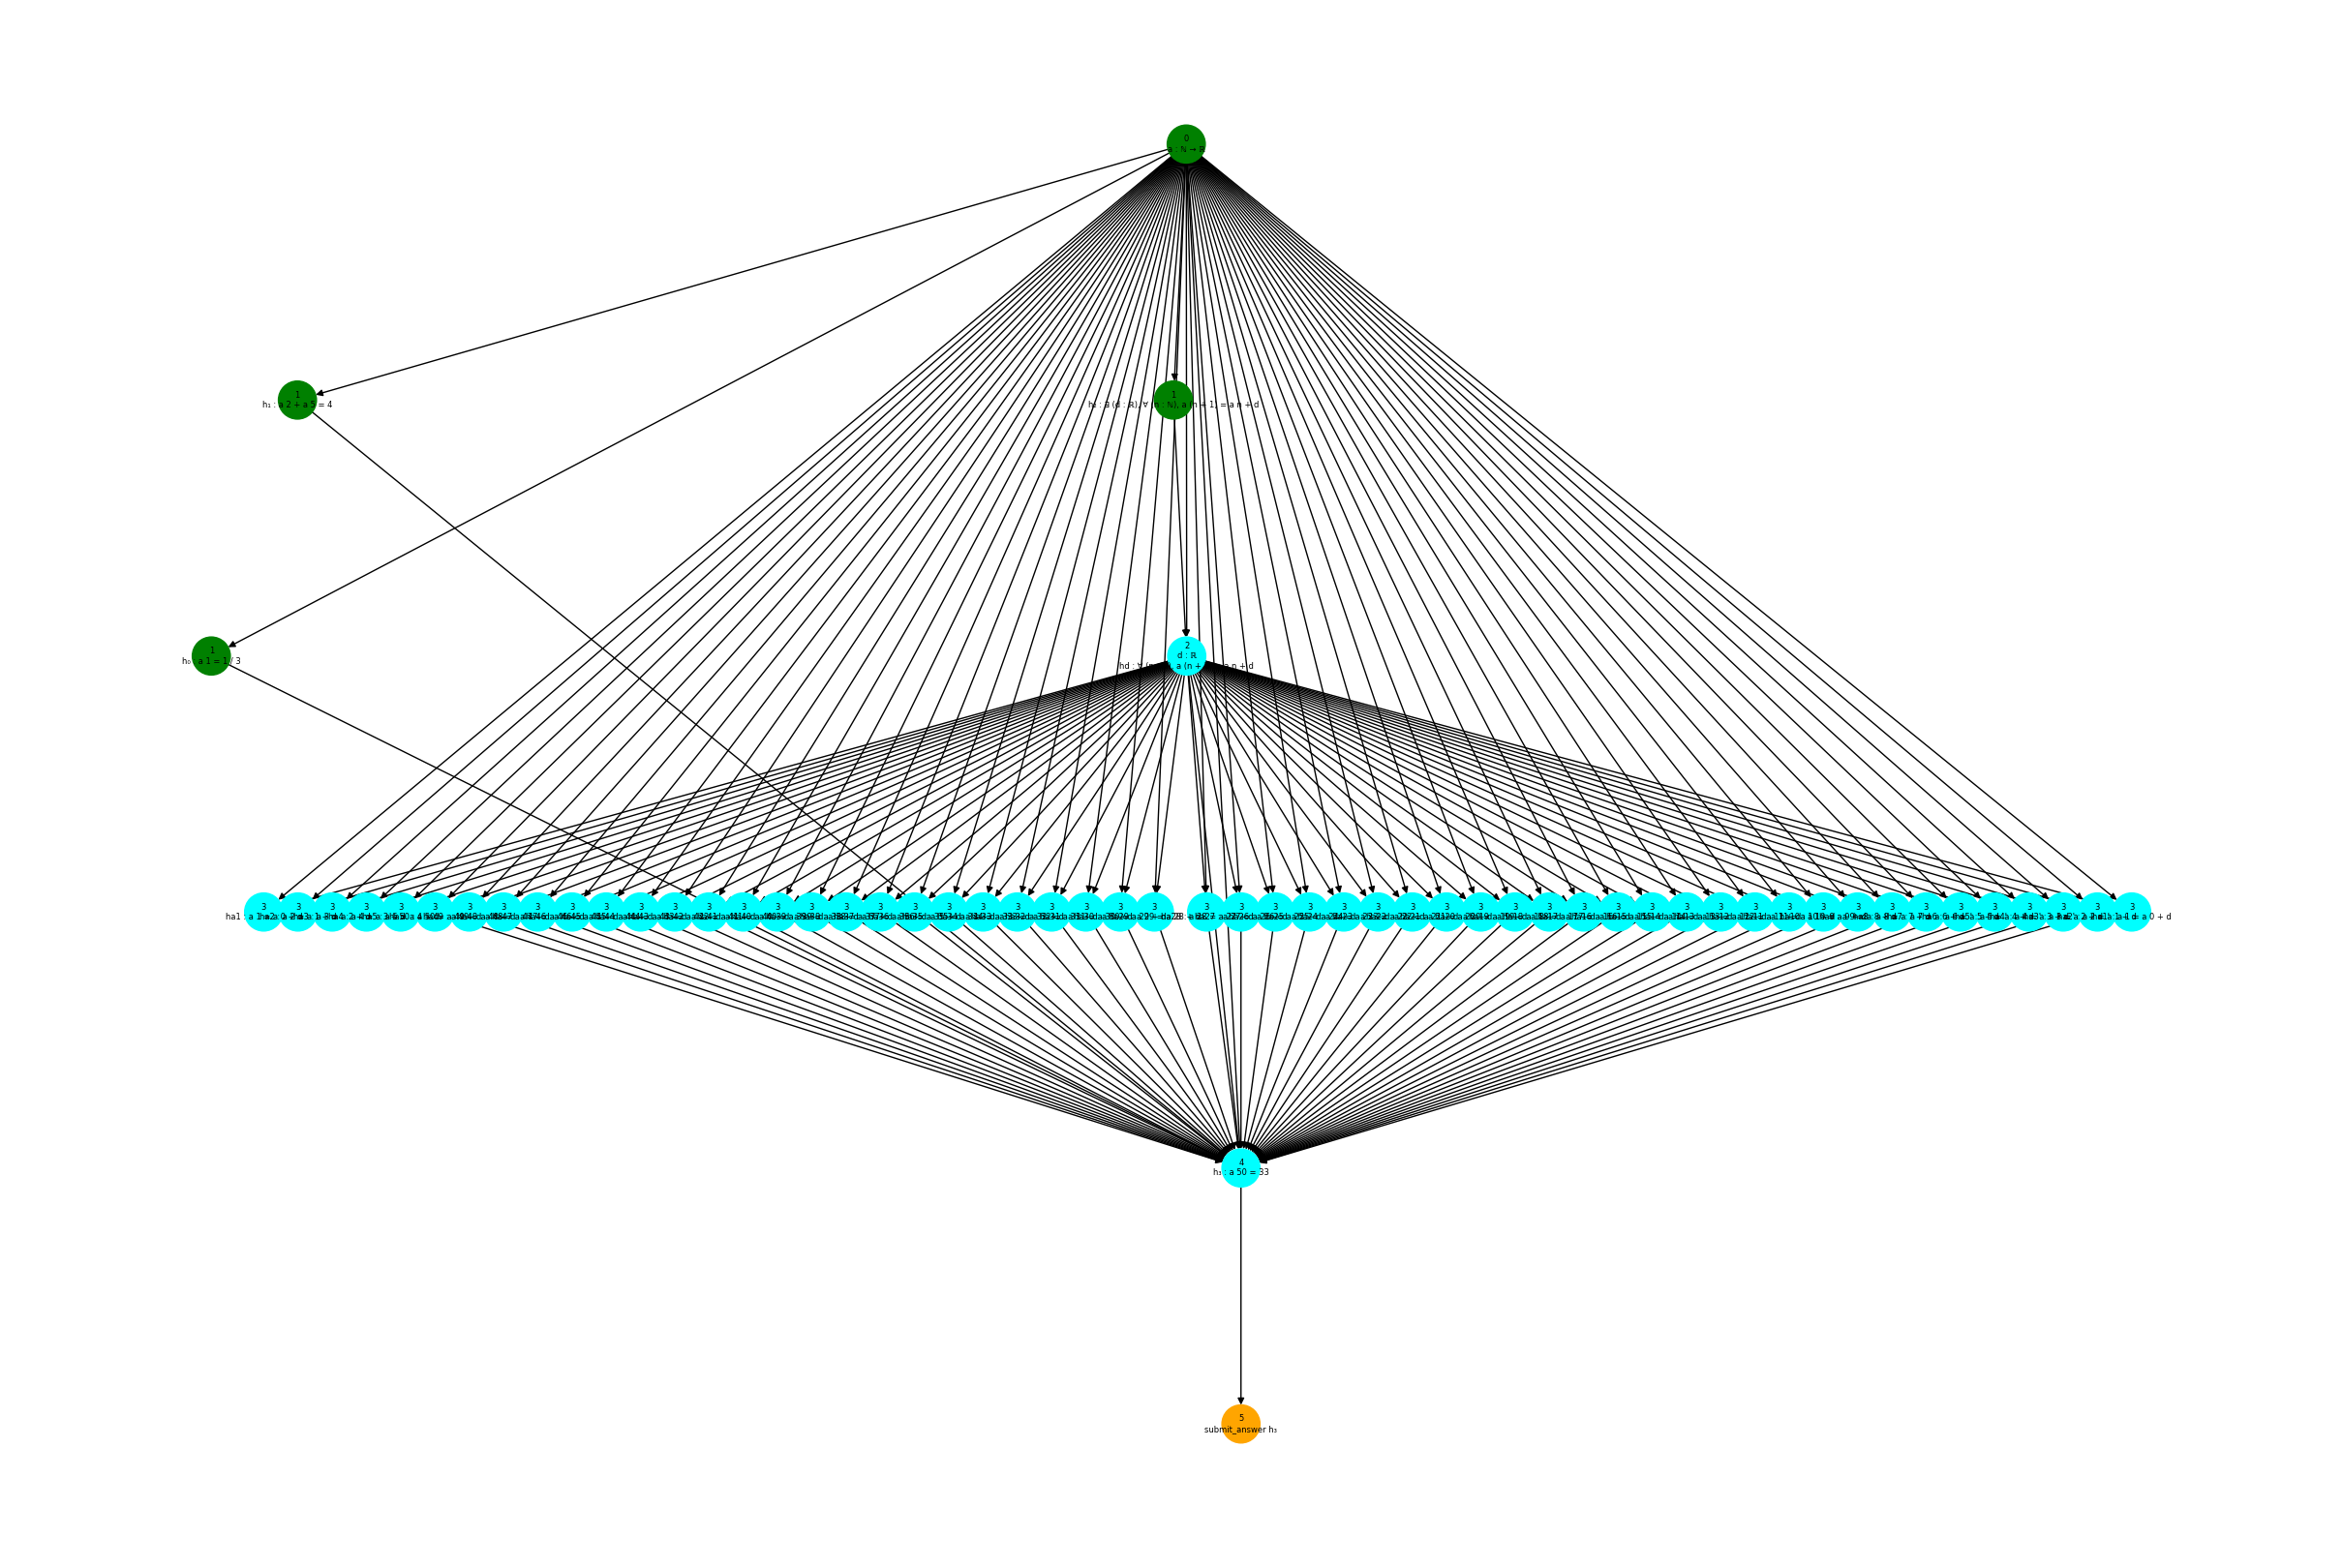

In [166]:
import matplotlib.pyplot as plt
import networkx as nx

dependency_graph = nx.DiGraph()
dependency_graph.add_edges_from(d.dependencies)

depth_dict = {n : 0 for n in range(len(d.steps))}
for u in nx.topological_sort(dependency_graph):
    for v in dependency_graph.successors(u):
        depth_dict[v] = max(depth_dict[v], depth_dict[u]+1)

plt.figure(figsize=(24, 16))
pos = nx.nx_agraph.graphviz_layout(dependency_graph, prog="dot", args="")
color_map = ['orange' if d.steps[int(node)].is_submitting else 'cyan' if d.steps[int(node)].is_deducing else 'green' for node in dependency_graph.nodes]
labels = {n: f'{depth_dict[n]}' + '\n' + '\n'.join(str(v) for v in (d.steps[n].new_contexts or [d.steps[n].step])) for n in dependency_graph.nodes}
# labels = {node: '\n'.join(str(v) for v in (steps[int(node)].new_contexts or [steps[int(node)].step])) for node in reduced_dependency_graph.nodes}
# order_dict = {n : i for i, (s, n) in enumerate(reassembled_trajectory)}
# labels = {n: f'{order_dict.get(n, "∞")}, {depth_dict[n]}' + '\n' + '\n'.join(str(v) for v in (steps[n].new_contexts or [steps[n].step])) for n in dependency_graph.nodes}
nx.draw(dependency_graph, pos, with_labels=True, labels=labels, node_size=800, font_size=6, node_color=color_map)
plt.tight_layout()
# plt.savefig(f'/home/ma-user/workspace/formal_problem_generation/formal_problem_generation/direct_dependency_graph.pdf')
plt.show()

In [191]:
G = dependency_graph.copy()
steps = d.steps[:]
reassembled_trajectory = []

submission_name = 'h₃'

In [71]:
server = PersistentServer(
    max_count=32,
    is_state_based=True,
    tag='',
    _sync_init=False,
    imports=["Mathlib", "Aesop"],
    project_path='/home/ma-user/workspace/formal_problem_generation/formal_problem_generation/data/MiniF2F',
    core_options=CORE_OPTIONS,
    timeout=300
)

In [192]:
deductive_state = await server.load_statement_async('False')

In [193]:
while True:
    available_actions = sorted([n for (n, d) in G.in_degree() if d == 0], key=lambda n : (-depth_dict[n], steps[n].is_introducing))
    is_success = False
    for i, action_id in enumerate(available_actions):   # If fail, fall back to other available actions
        try:
            chosen_action = steps[action_id]
            if chosen_action.is_submitting:
                submission_fvar_re = [v for v in deductive_state.goals[0].variables if v.name == submission_name]
                assert len(submission_fvar_re) == 1, f'submission_name={submission_name}, deductive_state={deductive_state}'
                submission_fvar_re = submission_fvar_re[0]
                # assert submission_fvar_re.t == submission_fvar.t, f'submission_fvar_re.t != submission_fvar.t: {submission_fvar_re.t} != {submission_fvar.t}'
                reassembled_trajectory.append((deductive_state.goals[0].variables, action_id))
                # if not set(deductive_state.goals[0].variables).issubset(set(result.trajectory[-1][0])):
                #     logger.warning(f'reassemble_trajectory_async({tag}): ¬(deductive_state ⊆ states[-1]): {[str(deductive_state.goals[0])], str(result.trajectory[-1][0])}')
                # result.metainfo['original_trajectory'] = [([v.serialize() for v in S], i_s) for (S, i_s) in result.trajectory]
                # result.trajectory = reassembled_trajectory
                # return True
                print(True)
                raise ValueError()
            new_deductive_state = await server.goal_tactic_async(deductive_state, 0, chosen_action.step)
            reassembled_trajectory.append((deductive_state.goals[0].variables, action_id))
            is_success = True
            G.remove_node(action_id)
            deductive_state = new_deductive_state
            print(chosen_action)
            break
        except Exception as e:
            # breakpoint()
            if isinstance(e, ValueError):
                raise
            logger.debug(f'reassemble_trajectory_async(): [{i}/{len(available_actions)}] available actions failed due to {repr(e)}')
    if not is_success:
        raise RuntimeError('All available actions failed.')

Introduce
```lean4
have a : ℕ → ℝ := sorry
```

Introduce
```lean4
have h₀ : a 1 = 1 / 3 := sorry
```

Introduce
```lean4
have h₁ : a 2 + a 5 = 4 := sorry
```

Introduce
```lean4
have h₂ : ∃ d, ∀ n, a (n + 1) = a n + d := sorry
```



Derive
```lean4
rcases h₂ with ⟨d, hd⟩
```

Derive
```lean4
have ha1 : a 1 = a 0 + d := by
  specialize hd 0
  norm_num at hd ⊢
  linarith
```

Derive
```lean4
have ha2 : a 2 = a 1 + d := by
  specialize hd 1
  norm_num at hd ⊢
  linarith
```

Derive
```lean4
have ha3 : a 3 = a 2 + d := by
  specialize hd 2
  norm_num at hd ⊢
  linarith
```

Derive
```lean4
have ha4 : a 4 = a 3 + d := by
  specialize hd 3
  norm_num at hd ⊢
  linarith
```

Derive
```lean4
have ha5 : a 5 = a 4 + d := by
  specialize hd 4
  norm_num at hd ⊢
  linarith
```

Derive
```lean4
have ha50 : a 50 = a 49 + d := by
  specialize hd 49
  norm_num at hd ⊢
  linarith
```

Derive
```lean4
have ha49 : a 49 = a 48 + d := by
  specialize hd 48
  norm_num at hd ⊢
  linarith
```

Derive
```lean4
have ha48 : a 48 = a 47 + d := by
  specialize hd 47
  norm_num at hd ⊢
  linarith
```

Derive
```lean4
have ha47 : a 47 = a 46 + d := by
  specialize hd 46
  norm_num at hd ⊢
  linarith
```

Derive
```lean4
have ha46 : a 46 = a 45 

ValueError: 

In [194]:
reassembled_trajectory == d.trajectory

False

In [200]:
set(range(62)) - set(t[-1] for t in reassembled_trajectory)

{59}

In [203]:
print(d.steps[59].step)

have ha1' : a 1 = a 0 + d := by
  specialize hd 0
  norm_num at hd ⊢
  linarith


In [204]:
for t in reassembled_trajectory:
    print(t[-1])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
60
61


In [189]:
C.Counter(t[-1] for t in reassembled_trajectory)

Counter({61: 2,
         0: 1,
         1: 1,
         2: 1,
         3: 1,
         4: 1,
         5: 1,
         6: 1,
         7: 1,
         8: 1,
         9: 1,
         10: 1,
         11: 1,
         12: 1,
         13: 1,
         14: 1,
         15: 1,
         16: 1,
         17: 1,
         18: 1,
         19: 1,
         20: 1,
         21: 1,
         22: 1,
         23: 1,
         24: 1,
         25: 1,
         26: 1,
         27: 1,
         28: 1,
         29: 1,
         30: 1,
         31: 1,
         32: 1,
         33: 1,
         34: 1,
         35: 1,
         36: 1,
         37: 1,
         38: 1,
         39: 1,
         40: 1,
         41: 1,
         42: 1,
         43: 1,
         44: 1,
         45: 1,
         46: 1,
         47: 1,
         48: 1,
         49: 1,
         50: 1,
         51: 1,
         52: 1,
         53: 1,
         54: 1,
         55: 1,
         56: 1,
         57: 1,
         58: 1,
         60: 1,
         59: 1})

In [190]:
for (i, t) in enumerate(reassembled_trajectory):
    if t[-1] == 61:
        print(i)

60
62


In [186]:
reassembled_trajectory[-2][-1]

59

In [187]:
d.trajectory[-1][-1]

61

In [173]:
submission_fvar_re

[]

In [171]:
print(f'reassemble_trajectory_async(): [{i}/{len(available_actions)}] available actions failed due to {repr(e)}')

NameError: name 'e' is not defined

In [144]:
for i in available_actions:
    print(depth_dict[i])

2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
